# CNN+LSTM 전력 수요 예측 

### <목차>

### <화면 가로 확장>

In [1]:
# 화면 가로 확장 코드 (기본 width 50%)
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

### 1. 모듈 임포트

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import tensorflow as tf
import csv
import os
import datetime
import time
import scipy.stats as stats
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
from scipy.stats import norm

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv1D, LSTM, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers.wrappers import TimeDistributed
import keras

In [3]:
try:
    os.mkdir('./Result')
    print('폴더 생성 완료.')
    
except FileExistsError:
    print('해당 폴더가 이미 존재합니다.')

해당 폴더가 이미 존재합니다.


### <GPU 확인>

In [4]:
tf.test.gpu_device_name()

'/device:GPU:0'

### 데이터 로드

In [5]:
Data_13=pd.read_csv('./Combined_Data_New/2013_House1_Ch1_Combined_Data_New_Y.csv', encoding='cp949')
Data_14=pd.read_csv('./Combined_Data_New/2014_House1_Ch1_Combined_Data_New_Y.csv', encoding='cp949')
Data_15=pd.read_csv('./Combined_Data_New/2015_House1_Ch1_Combined_Data_New_Y.csv', encoding='cp949')
Data_16=pd.read_csv('./Combined_Data_New/2016_House1_Ch1_Combined_Data_New_Y.csv', encoding='cp949')

In [6]:
Data_4Y = pd.read_csv('./Combined_Data_New/House1_Ch1_Combined_Data_New_13-16.csv', encoding='cp949')
Data_4Y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2102400 entries, 0 to 2102399
Data columns (total 8 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Unnamed: 0       int64  
 1   Year-Month-Date  object 
 2   Time             object 
 3   Holiday          int64  
 4   Watt             int64  
 5   Temp('C)         float64
 6   Humidity(%)      float64
 7   CPI              float64
dtypes: float64(3), int64(3), object(2)
memory usage: 128.3+ MB


In [7]:
Data_4Y

Unnamed: 0 Year-Month-Date       Time  Holiday  Watt  Temp('C)  \
0                 0      2013-01-01  [ 00:00 ]        1   522      10.0   
1                 1      2013-01-01  [ 00:01 ]        1   558      10.0   
2                 2      2013-01-01  [ 00:02 ]        1   537      10.0   
3                 3      2013-01-01  [ 00:03 ]        1   525      10.0   
4                 4      2013-01-01  [ 00:04 ]        1   539      10.0   
...             ...             ...        ...      ...   ...       ...   
2102395     2102395      2016-12-31  [ 23:55 ]        1   456       8.0   
2102396     2102396      2016-12-31  [ 23:56 ]        1   460       8.0   
2102397     2102397      2016-12-31  [ 23:57 ]        1   458       8.0   
2102398     2102398      2016-12-31  [ 23:58 ]        1   424       8.0   
2102399     2102399      2016-12-31  [ 23:59 ]        1   415       8.0   

         Humidity(%)  CPI  
0             87.000  2.7  
1             86.833  2.7  
2             86.667  2.7  
3             86.500  2.7  
4             86.333  2.7  
...              ...  ...  
2102395       88.000  1.6  
2102396       87.800  1.6  
2102397       87.600  1.6  
2102398       87.400  1.6  
2102399       87.000  1.6  

[2102400 rows x 8 columns]

In [27]:
def SimpleGraph(title, plot, ylabel, savename):
    plt.figure(figsize=(300,15))
    plt.grid()
    plt.title(title, fontsize=200)
    plt.plot(plot)

    plt.xlabel("Time by 1Minute", fontsize=150)
    plt.ylabel(ylabel, fontsize=150)
    plt.margins(x=0.002)

    plt.xticks([0, 525600, 525600*2, 525600*3], 
               labels=[2013, 2014, 2015, 2016])

    plt.tick_params(axis='x', size=15)
    plt.tick_params(axis='x', labelsize=50)
    plt.tick_params(axis='y', size=15)
    plt.tick_params(axis='y', labelsize=50)
    plt.savefig("./Result/"+savename+".png", bbox_inches='tight',pad_inches=1)
    plt.show()

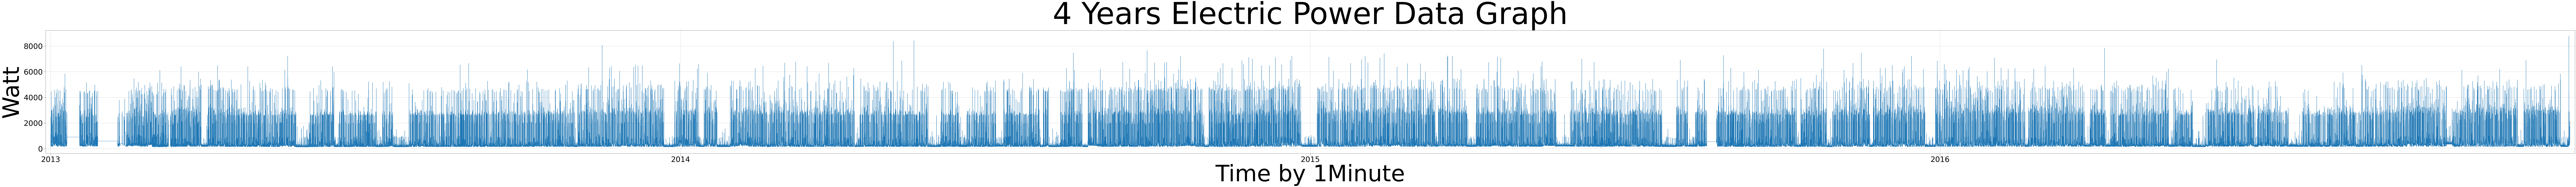

In [28]:
SimpleGraph("4 Years Electric Power Data Graph", Data_4Y["Watt"], "Watt", "4Years_Data_Watt")

### 이상치 처리

#### 전체 데이터(4년)의 이상치 판별 기준 추출

In [22]:
"""
def get_outlier(df=None, column=None, weight=None):
    quantile_25 = np.percentile(df[column].values, 25)
    quantile_50 = np.percentile(df[column].values, 50)
    quantile_75 = np.percentile(df[column].values, 75)
    
    IQR = quantile_75 - quantile_25
    IQR_weight = IQR * weight

    lowest_val = quantile_25-IQR_weight
    highest_val = quantile_75+IQR_weight
    
    outlier_index_low = df[column][df[column] < lowest_val].index
    outlier_index_high = df[column][df[column] > highest_val].index
    
    return outlier_index_low, outlier_index_high, quantile_25, quantile_50, quantile_75, lowest_val, highest_val
    """

In [13]:
def get_list_outlier(df=None, column=None, low=None, high=None):
    outlier_index_low = df[column][df[column] < low].index
    outlier_index_high = df[column][df[column] > high].index
    
    return outlier_index_low, outlier_index_high

In [17]:
one=(max(Data_4Y["Watt"])-min(Data_4Y["Watt"]))/100
Low_one=one*25
High_one=one*75
print(Low_one, High_one, (High_one-Low_one)*1.5)

2178.75 6536.25 6536.25


In [ ]:
"""
WEIGHT=3
Low_list=get_outlier(df=Data_4Y, column="Watt", weight=WEIGHT)[0]
High_list=get_outlier(df=Data_4Y, column="Watt", weight=WEIGHT)[1]
print('Low Outlier ==>> {}\n'.format(Low_list))
print('High Outlier ==>> {}\n'.format(High_list))

print("Ratio of High Outlier ==>> {} %\n".format(round(len(High_list)/len(Data_4Y),4)*100))

Value_25=get_outlier(df=Data_4Y, column="Watt", weight=WEIGHT)[2]
Value_50=get_outlier(df=Data_4Y, column="Watt", weight=WEIGHT)[3]
Value_75=get_outlier(df=Data_4Y, column="Watt", weight=WEIGHT)[4]
print('25%_Value ==>> {}\n'.format(Value_25))
print('50%_Value ==>> {}\n'.format(Value_50))
print('75%_Value ==>> {}\n'.format(Value_75))

Lowest_Line=get_outlier(df=Data_4Y, column="Watt", weight=WEIGHT)[5]
Highest_Line=get_outlier(df=Data_4Y, column="Watt", weight=WEIGHT)[6]

print('Lowest Line ==>> {}\n'.format(Lowest_Line))
print('Highest Line ==>> {}\n'.format(Highest_Line))
"""

In [24]:
High_list_13=get_list_outlier(df=Data_13, column="Watt", low=Low_one, high=High_one)[1]
High_list_14=get_list_outlier(df=Data_14, column="Watt", low=Low_one, high=High_one)[1]
High_list_15=get_list_outlier(df=Data_15, column="Watt", low=Low_one, high=High_one)[1]
print("High List >>", len(High_list_13), len(High_list_14), len(High_list_15))

High List >> 7 52 60


In [25]:
for i in High_list_13:
    Data_13["Watt"][i:i+1] = High_one
for i in High_list_14:
    Data_14["Watt"][i:i+1] = High_one
for i in High_list_15:
    Data_15["Watt"][i:i+1] = High_one

C:\Users\82108\AppData\Local\Temp/ipykernel_12156/3943759054.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Data_13["Watt"][i:i+1] = High_one
C:\Users\82108\AppData\Local\Temp/ipykernel_12156/3943759054.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Data_14["Watt"][i:i+1] = High_one
C:\Users\82108\AppData\Local\Temp/ipykernel_12156/3943759054.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Data_15["Watt"][i:i+1] = High_on

In [26]:
High_list_13=get_list_outlier(df=Data_13, column="Watt", low=Low_one, high=High_one)[1]
High_list_14=get_list_outlier(df=Data_14, column="Watt", low=Low_one, high=High_one)[1]
High_list_15=get_list_outlier(df=Data_15, column="Watt", low=Low_one, high=High_one)[1]
print(len(High_list_13), len(High_list_14), len(High_list_15))

0 0 0


In [27]:
df_4Y = pd.DataFrame()
df_4Y = pd.concat([df_4Y, Data_13])
df_4Y = pd.concat([df_4Y, Data_14])
df_4Y = pd.concat([df_4Y, Data_15])
df_4Y = pd.concat([df_4Y, Data_16])
    
df_4Y = df_4Y.drop([df_4Y.columns[0]], axis=1)
df_4Y = df_4Y.reset_index(drop=True)
df_4Y.to_csv("./Combined_Data_New/House1_Ch1_Combined_Data_New_13-16_Outlier_Edited.csv", encoding='cp949')
print("Done!")

Done!


In [14]:
Data_4Y_Edited = pd.read_csv('./Combined_Data_New/House1_Ch1_Combined_Data_New_13-16_Outlier_Edited.csv', encoding='cp949')
Data_4Y_Edited.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2102400 entries, 0 to 2102399
Data columns (total 8 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Unnamed: 0       int64  
 1   Year-Month-Date  object 
 2   Time             object 
 3   Holiday          int64  
 4   Watt             float64
 5   Temp('C)         float64
 6   Humidity(%)      float64
 7   CPI              float64
dtypes: float64(4), int64(2), object(2)
memory usage: 128.3+ MB


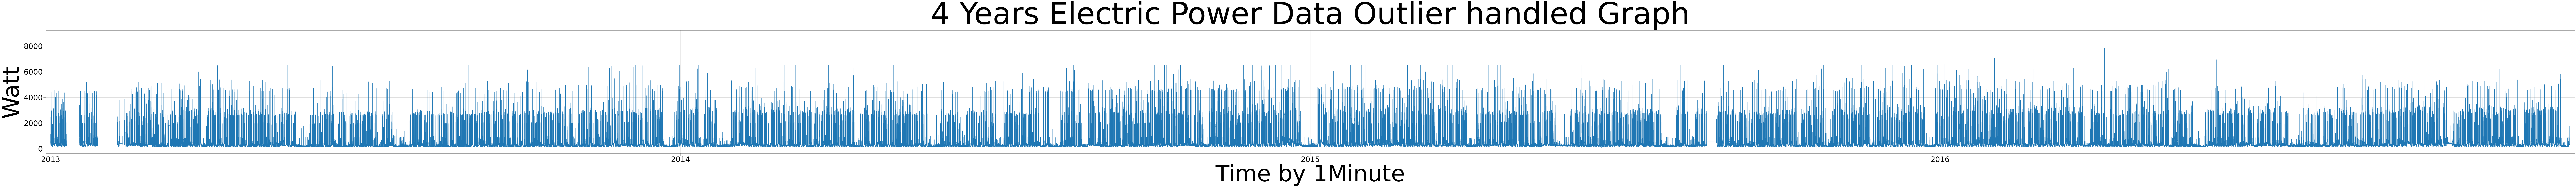

In [29]:
SimpleGraph("4 Years Electric Power Data Outlier handled Graph", Data_4Y_Edited["Watt"], "Watt", "4Years_Outlier_Edited_Data_Watt")

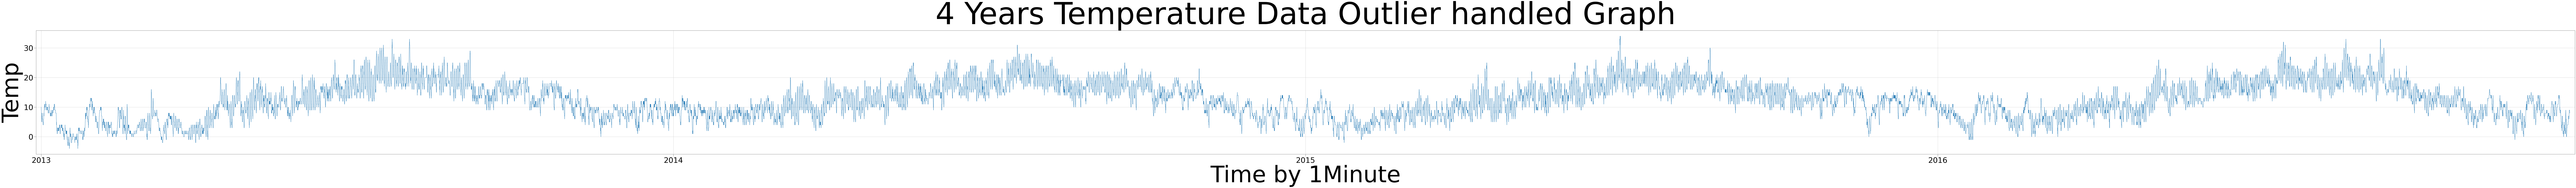

In [30]:
SimpleGraph("4 Years Temperature Data Outlier handled Graph", Data_4Y_Edited["Temp('C)"], "Temp", "4Years_Outlier_Edited_Data_Temp")

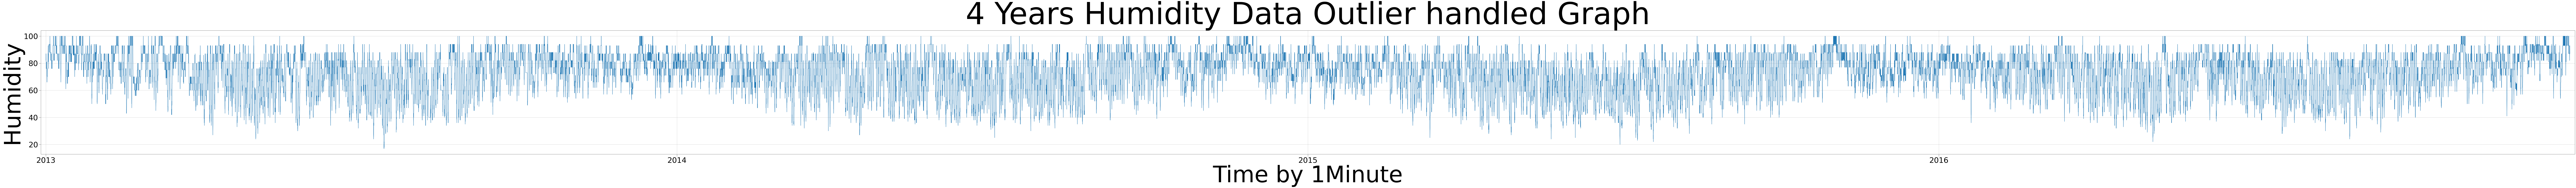

In [31]:
SimpleGraph("4 Years Humidity Data Outlier handled Graph", Data_4Y_Edited["Humidity(%)"], "Humidity", "4Years_Outlier_Edited_Data_Humidity")

### SPSS 사용을 위한 Excel 파일 저장

In [10]:
"""
Data_SPSS = Data_4Y[["Year-Month-Date", "Time", "Holiday", "Watt", "Temp('C)", "Humidity(%)", "CPI"]]
Data_SPSS.to_excel('./Combined_Data/Data_SPSS.xlsx')
"""

### 연관성 검사 분석

In [32]:
# 피어슨 stat을 이용하면 피어슨 상관계수와 p-value값이 출력되는데 상관계수는 양 or 음의 비례관계 정도를, p-value는 상관 정도를 보여준다. (0에 가까울수록 영향이 크다.)

Correlation=stats.pearsonr(Data_4Y_Edited['Holiday'], Data_4Y_Edited['Watt'])
print('< Holiday - Watt >')
print('P-value >> %.3f' %Correlation[1])
print('Total P-value >> %.40f\n' %Correlation[1])

Correlation=stats.pearsonr(Data_4Y_Edited["Temp('C)"], Data_4Y_Edited['Humidity(%)'])
print('< Temp - Humidity >')
print('P-value >> %.3f' %Correlation[1])
print('Total P-value >> %.40f\n' %Correlation[1])

Correlation=stats.pearsonr(Data_4Y_Edited["Temp('C)"], Data_4Y_Edited['Watt'])
print('< Temp - Watt >')
print('P-value >> %.3f' %Correlation[1])
print('Total P-value >> %.40f\n' %Correlation[1])

Correlation=stats.pearsonr(Data_4Y_Edited['Humidity(%)'], Data_4Y_Edited['Watt'])
print('< Humidity - Watt >')
print('P-value >> %.3f' %Correlation[1])
print('Total P-value >> %.60f\n' %Correlation[1])

Correlation=stats.pearsonr(Data_4Y_Edited['CPI'], Data_4Y_Edited['Watt'])
print('< CPI - Watt >')
print('P-value >> %.3f' %Correlation[1])
print('Total P-value >> %.40f\n' %Correlation[1])

< Holiday - Watt >
P-value >> 0.000
Total P-value >> 0.0000000000000000000000000000000000000000

< Temp - Humidity >
P-value >> 0.000
Total P-value >> 0.0000000000000000000000000000000000000000

< Temp - Watt >
P-value >> 0.000
Total P-value >> 0.0000000000000000000000000000000000000000

< Humidity - Watt >
P-value >> 0.000
Total P-value >> 0.000000000000000000000000000000000000000000000000000000000000

< CPI - Watt >
P-value >> 0.000
Total P-value >> 0.0000000000000000000000000000000000000000



### 4. 데이터 정규화

#### Min-Max Scaling 이용, 4년치 학습 데이터 정규화

In [33]:
"""
<StandardScaler>
from sklearn.preprocessing import StandardScaler
평균 0, 분산1 로 조정
가우시안 분포된 선형 데이터나 SVM에 사용

<RobustScaler>
from sklearn.preprocessing import RobustScaler
평균과 분산 대신 중간값과 사분위 값을 사용.
이상치에 Robustic한 반응을 보임.

<MinMaxScaler>
모든 값을 0~1 사이로 정규화
원데이터 분포를 유지하면서 정규화하는 방법
가우시안 분포를 띄지 않는 데이터에 사용

<Normalizer>
from sklearn.preprocessing import Normalizer
특성 벡터의 모든 길이가 1이 되도록 조정, 
특성 벡터의 길이보다는 데이터의 방향이나 각도가 중요할 경우 사용

<QuantileTransformer>
from sklearn.preprocessing import QuantileTransformer
1000개의 분위를 사용하여 데이터를 균등분포 시킴.
Robustic한 특성을 지니며, 데이터들은 0~1 사이로 압축됨.

<PowerTransformer>
from sklearn.preprocessing import PowerTransformer
데이터의 특성별로 정규분포 형태에 가깝도록 변환
"""

'\n<StandardScaler>\nfrom sklearn.preprocessing import StandardScaler\n평균 0, 분산1 로 조정\n가우시안 분포된 선형 데이터나 SVM에 사용\n\n<RobustScaler>\nfrom sklearn.preprocessing import RobustScaler\n평균과 분산 대신 중간값과 사분위 값을 사용.\n이상치에 Robustic한 반응을 보임.\n\n<MinMaxScaler>\n모든 값을 0~1 사이로 정규화\n원데이터 분포를 유지하면서 정규화하는 방법\n가우시안 분포를 띄지 않는 데이터에 사용\n\n<Normalizer>\nfrom sklearn.preprocessing import Normalizer\n특성 벡터의 모든 길이가 1이 되도록 조정, \n특성 벡터의 길이보다는 데이터의 방향이나 각도가 중요할 경우 사용\n\n<QuantileTransformer>\nfrom sklearn.preprocessing import QuantileTransformer\n1000개의 분위를 사용하여 데이터를 균등분포 시킴.\nRobustic한 특성을 지니며, 데이터들은 0~1 사이로 압축됨.\n\n<PowerTransformer>\nfrom sklearn.preprocessing import PowerTransformer\n데이터의 특성별로 정규분포 형태에 가깝도록 변환\n'

In [37]:
# 정규화 과정을 거쳐 데이터 범위를 원하는 범위로 제한. 그래프는 동일하나 손실 정도를 확인하기에 더 좋음.
# 배치 정규화는 기울기 소멸 문제를 해결하기는 좋으나, RNN의 경우 계층별로 미니 정규화 적용이 필요해 모델이 복잡해지고 효율이 저하됨.
Data_4Y_Edited.sort_index(ascending=False).reset_index(drop=True)
from sklearn.preprocessing import PowerTransformer, QuantileTransformer
scaler=MinMaxScaler()

scale_cols = ["Holiday", "Watt", "Temp('C)", "Humidity(%)", "CPI"]
Data_4Y_scaled = scaler.fit_transform(Data_4Y_Edited[scale_cols])
Data_4Y_scaled = pd.DataFrame(Data_4Y_scaled)
Data_4Y_scaled.columns = scale_cols

"""
Data_4Y_scaled.insert(2, "Watt2", Data_4Y_scaled["Watt"])
Data_4Y_scaled=Data_4Y_scaled[["Holiday","Temp('C)", "CPI", "Humidity(%)", "Watt", "Watt2"]]

Data_MinMax_SPSS=Data_4Y_scaled[["Holiday","Temp('C)", "Humidity(%)", "CPI", "Watt"]]
Data_MinMax_SPSS.to_excel('./Combined_Data/Data_MinMax_SPSS.xlsx')
"""

'\nData_4Y_scaled.insert(2, "Watt2", Data_4Y_scaled["Watt"])\nData_4Y_scaled=Data_4Y_scaled[["Holiday","Temp(\'C)", "CPI", "Humidity(%)", "Watt", "Watt2"]]\n\nData_MinMax_SPSS=Data_4Y_scaled[["Holiday","Temp(\'C)", "Humidity(%)", "CPI", "Watt"]]\nData_MinMax_SPSS.to_excel(\'./Combined_Data/Data_MinMax_SPSS.xlsx\')\n'

#### 정규분포 시각화

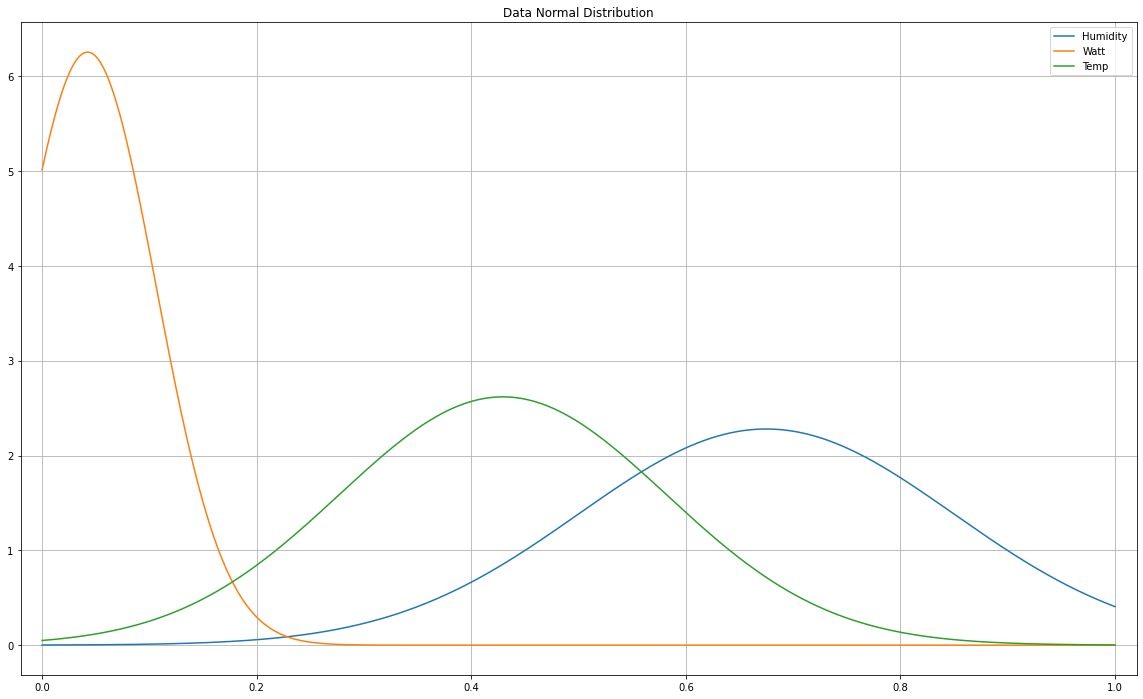

In [38]:
plt.figure(figsize=(20,12))
plt.grid()
plt.title("Data Normal Distribution")
#plt.plot(np.sort(Data_4Y_scaled["Holiday"]), norm.pdf(np.sort(Data_4Y_scaled["Holiday"]), np.mean(Data_4Y_scaled["Holiday"]), np.std(Data_4Y_scaled["Holiday"])), label="Holiday")
plt.plot(np.sort(Data_4Y_scaled["Humidity(%)"]), norm.pdf(np.sort(Data_4Y_scaled["Humidity(%)"]), np.mean(Data_4Y_scaled["Humidity(%)"]), np.std(Data_4Y_scaled["Humidity(%)"])), label="Humidity")
plt.plot(np.sort(Data_4Y_scaled["Watt"]), norm.pdf(np.sort(Data_4Y_scaled["Watt"]), np.mean(Data_4Y_scaled["Watt"]), np.std(Data_4Y_scaled["Watt"])), label="Watt")
plt.plot(np.sort(Data_4Y_scaled["Temp('C)"]), norm.pdf(np.sort(Data_4Y_scaled["Temp('C)"]), np.mean(Data_4Y_scaled["Temp('C)"]), np.std(Data_4Y_scaled["Temp('C)"])), label="Temp")
plt.legend()
plt.margins(x=0.02)
#plt.savefig('./Result/Data_Normal_Distribution_QuantileTransformer.png')
plt.show()

In [39]:
# 피어슨 stat을 이용하면 피어슨 상관계수와 p-value값이 출력되는데 상관계수는 양 or 음의 비례관계 정도를, p-value는 상관 정도를 보여준다. (0에 가까울수록 영향이 크다.)

Correlation=stats.pearsonr(Data_4Y_scaled['Holiday'], Data_4Y_scaled['Watt'])
print('< Holiday - Watt >')
print('P-value >> %.3f' %Correlation[1])
print('Total P-value >> %.100f\n' %Correlation[1])

Correlation=stats.pearsonr(Data_4Y_scaled["Temp('C)"], Data_4Y_scaled['Humidity(%)'])
print('< Temp - Humidity >')
print('P-value >> %.3f' %Correlation[1])
print('Total P-value >> %.100f\n' %Correlation[1])

Correlation=stats.pearsonr(Data_4Y_scaled["Temp('C)"], Data_4Y_scaled['Watt'])
print('< Temp - Watt >')
print('P-value >> %.3f' %Correlation[1])
print('Total P-value >> %.100f\n' %Correlation[1])

Correlation=stats.pearsonr(Data_4Y_scaled['Humidity(%)'], Data_4Y_scaled['Watt'])
print('< Humidity - Watt >')
print('P-value >> %.3f' %Correlation[1])
print('Total P-value >> %.100f\n' %Correlation[1])

Correlation=stats.pearsonr(Data_4Y_scaled['CPI'], Data_4Y_scaled['Watt'])
print('< CPI - Watt >')
print('P-value >> %.3f' %Correlation[1])
print('Total P-value >> %.100f\n' %Correlation[1])

< Holiday - Watt >
P-value >> 0.000
Total P-value >> 0.0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000

< Temp - Humidity >
P-value >> 0.000
Total P-value >> 0.0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000

< Temp - Watt >
P-value >> 0.000
Total P-value >> 0.0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000

< Humidity - Watt >
P-value >> 0.000
Total P-value >> 0.0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000

< CPI - Watt >
P-value >> 0.000
Total P-value >> 0.0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000



#### 전력 데이터 변화폭 재확인

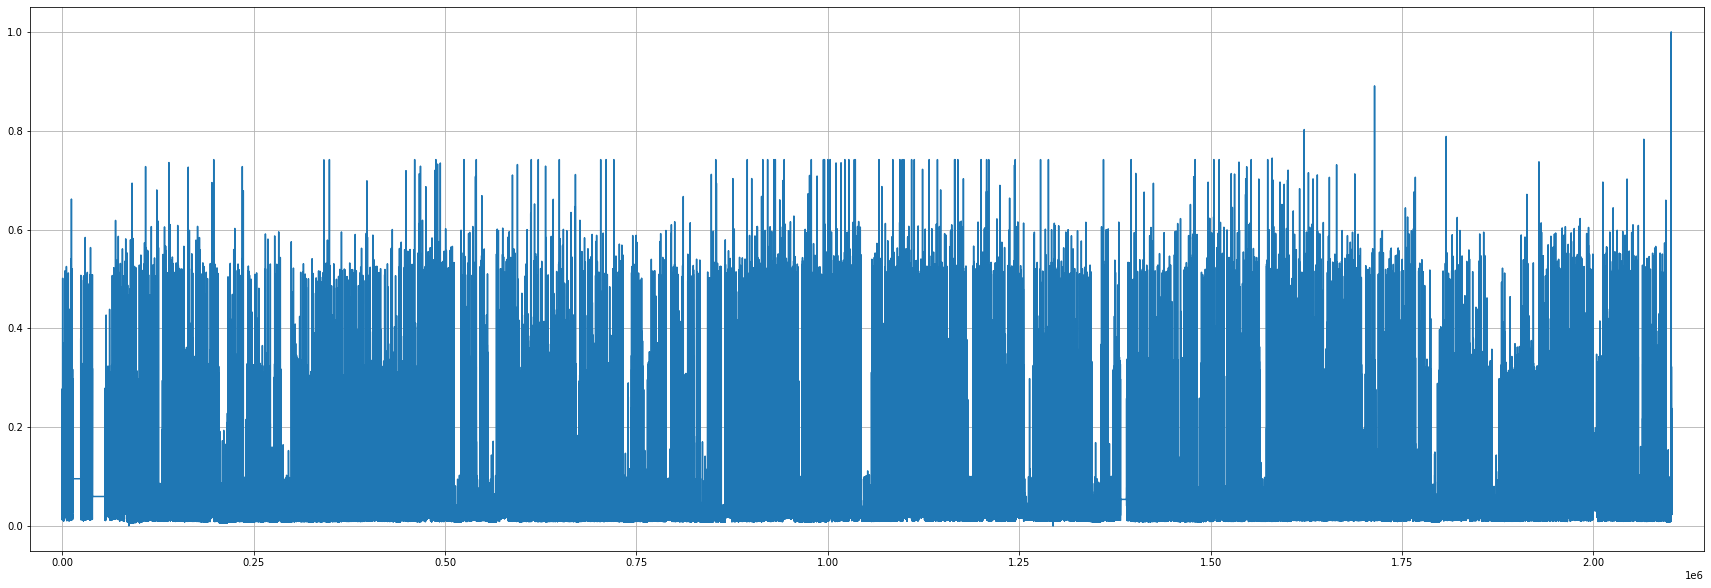

In [40]:
plt.figure(figsize=(30,10))
plt.grid()
plt.margins(x=0.02)
plt.plot(Data_4Y_scaled["Watt"])
plt.show()

### 7. 데이터셋 편집

In [45]:
TEST_SIZE = 1*60*24*365 #1년치를 테스트셋으로 사용
WINDOW_SIZE = 60 #얼마 동안의 과거 기반의 데이터로 다음값을 예측할 것인지 설정. 
BATCH_SIZE = 128 #128
VAL_DAYS = 525600

In [46]:
# train과 test셋 분할
learning = Data_4Y_scaled[:-TEST_SIZE] # 학습에 쓰이는 전체 데이터
VAL_RATIO=VAL_DAYS/len(learning)
VAL_SIZE = int(len(learning)*VAL_RATIO)
TRAIN = learning[:-VAL_SIZE]
VAL = learning[-VAL_SIZE:]
TEST = Data_4Y_scaled[-(TEST_SIZE+WINDOW_SIZE):]
print(len(TRAIN), len(VAL), len(TEST))

1051200 525600 525660


In [47]:
def windowed_dataset(series, window_size, batch_size, shuffle):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    return ds.batch(batch_size).prefetch(1)

In [48]:
train_data = windowed_dataset(TRAIN, WINDOW_SIZE, BATCH_SIZE, False) 
valid_data = windowed_dataset(VAL, WINDOW_SIZE, BATCH_SIZE, False)
test_data = windowed_dataset(TEST, WINDOW_SIZE, BATCH_SIZE, False)

### 8. 딥러닝 모델

In [49]:
LeakyReLU=tf.keras.layers.LeakyReLU(alpha=1.0)

model = Sequential([
    Conv1D(filters=64, kernel_size=7, padding="same", input_shape=[WINDOW_SIZE, TRAIN.shape[1]]),
    Bidirectional(LSTM(4, activation=LeakyReLU, return_sequences=True), merge_mode='concat'),
    TimeDistributed(Dense(4)),
    Bidirectional(LSTM(2, activation=LeakyReLU, return_sequences=False), merge_mode='concat'),
    Dense(1)
                    ])
"""
model = Sequential([
    Conv1D(filters=64, kernel_size=9, padding="same", input_shape=[WINDOW_SIZE, TRAIN.shape[1]]),
    Bidirectional(LSTM(8, activation=LeakyReLU, return_sequences=True), merge_mode='concat'),
    TimeDistributed(Dense(16)),
    Bidirectional(LSTM(4, activation=LeakyReLU, return_sequences=True), merge_mode='concat'),
    TimeDistributed(Dense(8)),
    Bidirectional(LSTM(4, activation=LeakyReLU, return_sequences=True), merge_mode='concat'),
    TimeDistributed(Dense(8)),
    Bidirectional(LSTM(4, activation=LeakyReLU, return_sequences=False), merge_mode='concat'),
    Dense(1)
                    ])
"""

model.summary()
model.compile(loss='mean_absolute_error', optimizer='Nadam')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 60, 64)            2304      
                                                                 
 bidirectional (Bidirectiona  (None, 60, 8)            2208      
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 60, 4)            36        
 ibuted)                                                         
                                                                 
 bidirectional_1 (Bidirectio  (None, 4)                112       
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 1)                 5         
                                                        

#### Plot model 저장

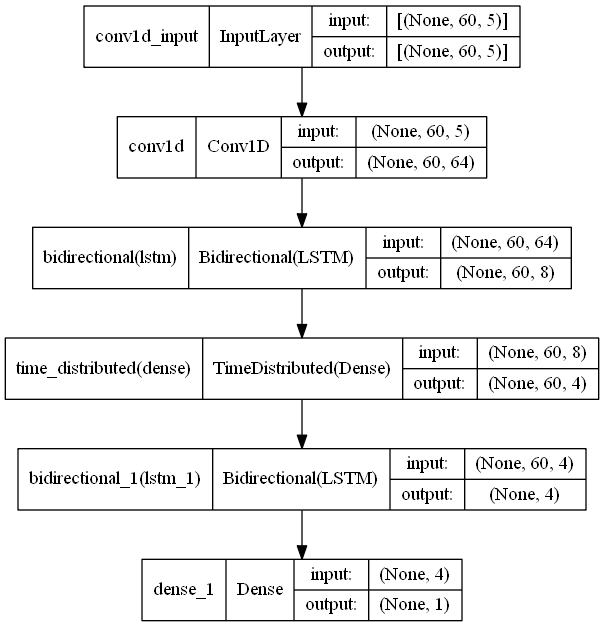

In [50]:
from keras.utils.vis_utils import plot_model
import pydot
import pydotplus
import graphviz

plot_model(model, to_file='./Result/CNN+LSTM/model.png')
plot_model(model, to_file='./Result/CNN+LSTM/model_shapes.png', show_shapes=True)

#### 학습

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=3)

with tf.device('/GPU:0'):
    model_path = 'model'
    filename = os.path.join(model_path, 'tmp_checkpoint_CL.h5')
    checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
    history = model.fit(train_data, epochs=5, batch_size=BATCH_SIZE, validation_data=(valid_data), callbacks=[checkpoint])

Epoch 1/5
   1474/Unknown - 946s 635ms/step - loss: 0.3341

In [ ]:
model.load_weights(filename)
pred = model.predict(test_data)
pred.shape

### 9. 결과 표시

In [ ]:
try:
    os.mkdir('./Result/CNN+LSTM')
    os.mkdir('./Result/CNN+LSTM/Graph')
    os.mkdir('./Result/CNN+LSTM/Data')
    print('폴더 생성 완료.')
    
except FileExistsError:
    print('해당 폴더가 이미 존재합니다.')

In [ ]:
plt.figure(figsize=(16, 10))
plt.title('Model Validation Loss', size='15')
plt.xlabel('Epoch')
plt.ylabel('Val_loss')
plt.grid(True)
plt.plot(history.history['val_loss'])
plt.margins(x=0.02)
plt.savefig('./Result/CNN+LSTM/Graph/Model_Valdation_Loss.png')
plt.show

In [ ]:
plt.figure(figsize=(16, 10))
plt.title('Model Loss Convergence Graph', size='15')
y_tloss = history.history['loss']
y_vloss = history.history['val_loss']
x_len = np.arange(len(y_tloss))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(range(0,200,10), labels=range(1,201, 10))

plt.plot(x_len, y_tloss, "o-", c="blue", markersize=3)
plt.plot(x_len, y_vloss, "o-", c="red", markersize=3)
plt.margins(x=0.02)
plt.legend(['Training loss', 'Validation loss'])
plt.savefig('./Result/CNN+LSTM/Graph/Model_Loss_Convergence_Graph.png')
plt.show

In [ ]:
plt.figure(figsize=(300, 15))

plt.tick_params(axis='x', colors='blue', size=15)
plt.tick_params(axis='x', colors='blue', labelsize=12)
plt.tick_params(axis='y', colors='blue', size=15)
plt.tick_params(axis='y', colors='blue', labelsize=12)

plt.plot(pred, label = 'Prediction',color='blue')

plt.xticks([0, 31*24*60, 59*24*60, 90*24*60, 120*24*60, 151*24*60, 181*24*60, 212*24*60, 243*24*60, 273*24*60, 304*24*60, 334*24*60], 
           labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.yticks([0, 0.111, 0.222, 0.333, 0.444, 0.555, 0.666, 0.777, 0.888, 1.0], 
           labels=['0', '1000 W', '2000 W', '3000 W', '4000 W', '5000 W', '6000 W', '7000 W', '8000 W','9000 W'])

plt.margins(x=0.005)
plt.savefig('./Result/CNN+LSTM/Graph/Prediction.png')
plt.show()

In [ ]:
plt.figure(figsize=(300, 15))

plt.tick_params(axis='x', colors='darkorange', size=15)
plt.tick_params(axis='x', colors='darkorange', labelsize=12)
plt.tick_params(axis='y', colors='darkorange', size=15)
plt.tick_params(axis='y', colors='darkorange', labelsize=12)

#x=test['Graph_Date']

plt.plot(TEST['Watt'][:-WINDOW_SIZE], label = 'Actual', color='darkorange')

#plt.xticks([0, 31*24, 59*24, 90*24, 120*24, 151*24, 181*24, 212*24, 243*24, 273*24, 304*24, 334*24], labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.yticks([0, 0.111, 0.222, 0.333, 0.444, 0.555, 0.666, 0.777, 0.888, 1.0], 
           labels=['0', '1000 W', '2000 W', '3000 W', '4000 W', '5000 W', '6000 W', '7000 W', '8000 W','9000 W'])

plt.margins(x=0.005)
plt.savefig('./Result/CNN+LSTM/Graph/Actual.png')
plt.show()

In [ ]:
fig = plt.figure(figsize=(300,15)) 
ax1 = fig.add_subplot() # subplot 그래프 생성
ax1.tick_params(axis='y', size=20, labelsize=20) # y축 눈금 표기 설정
plt.yticks([0, 0.111, 0.222, 0.333, 0.444, 0.555, 0.666, 0.777, 0.888, 1.0], 
           labels=['0', '1000 W', '2000 W', '3000 W', '4000 W', '5000 W', '6000 W', '7000 W', '8000 W','9000 W'])

color1 = 'darkorange'
ax1.plot(TEST['Watt'][:-WINDOW_SIZE], color=color1)
#ax1.set_ylabel('y', size=20)
ax1.tick_params(axis='y')
ax1.tick_params(axis='x', size=20, labelsize=20)
ax1.margins(x=0.005)
"""
ax1.set_xticks([26280, 26280+31*24, 26280+59*24, 26280+90*24, 26280+120*24, 26280+151*24, 26280+181*24, 26280+212*24, 26280+243*24, 26280+273*24, 26280+304*24, 26280+334*24], 
           labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']) # x1의 칸당 간격(=ticks) 설정
           """
ax1.legend(['Actual'], loc=1, bbox_to_anchor=(0.995, 1, 0, 0))

color2 = 'blue'
ax2 = ax1.twiny()
ax2.plot(pred, color=color2)
ax2.tick_params(axis='x', size=20, labelsize=20)
ax2.margins(x=0.005)
"""
ax2.set_xticks([0, 31*24, 59*24, 90*24, 120*24, 151*24, 181*24, 212*24, 243*24, 273*24, 304*24, 334*24], 
           labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']) # x1의 칸당 간격(=ticks) 설정
           """
ax2.legend(['Predict'], loc=1, bbox_to_anchor=(1, 1, 0, 0))

plt.savefig('./Result/CNN+LSTM/Graph/Pred_with_Actual.png')
plt.show()

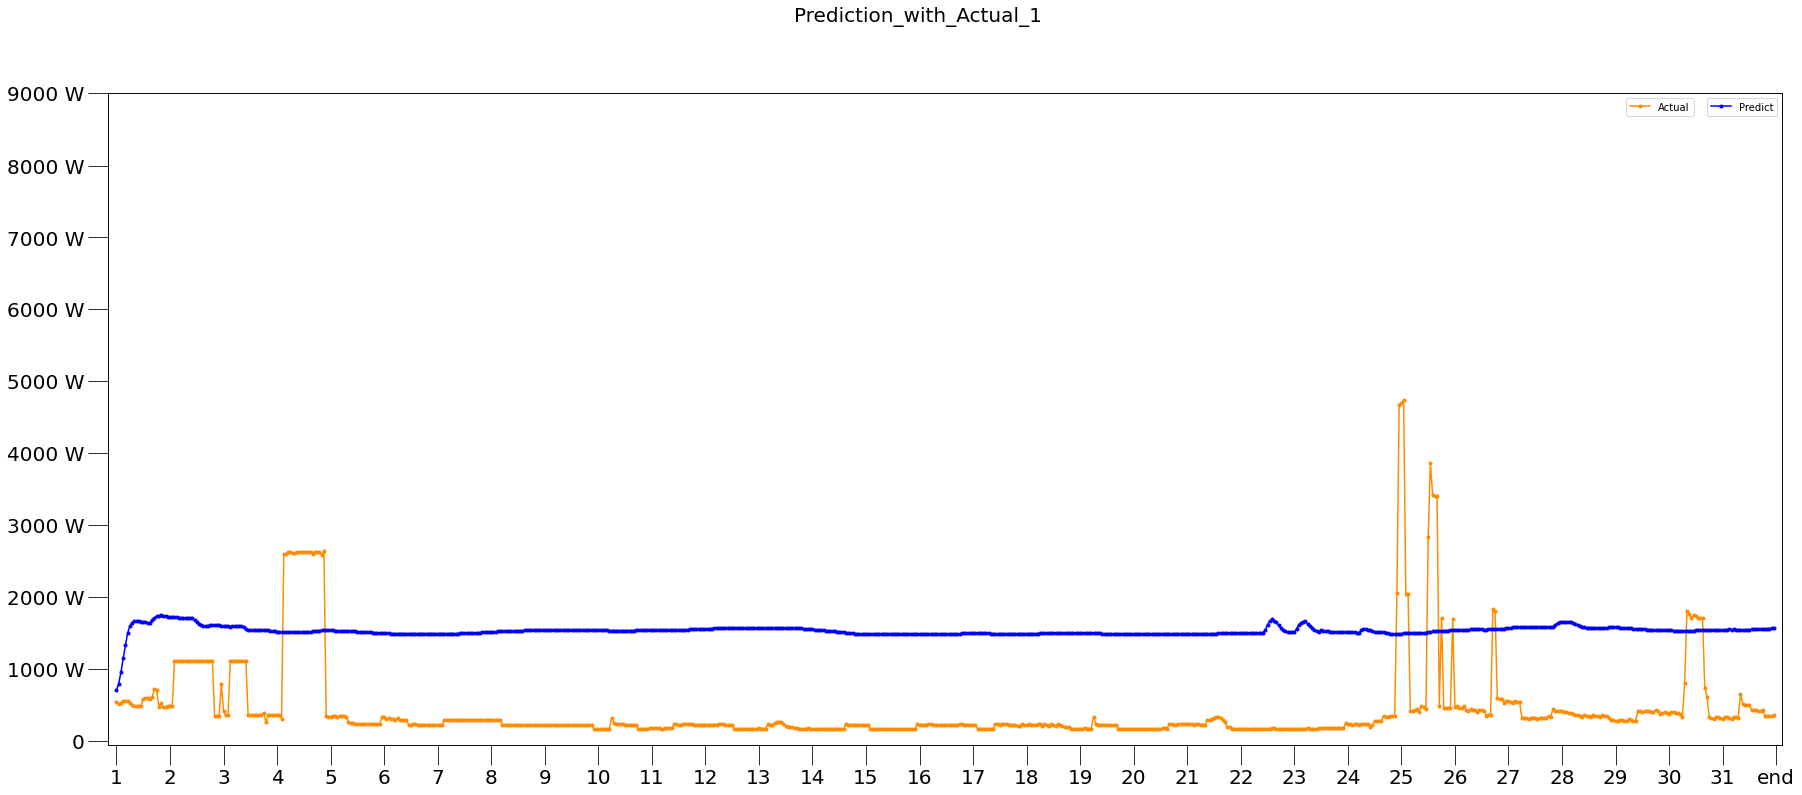

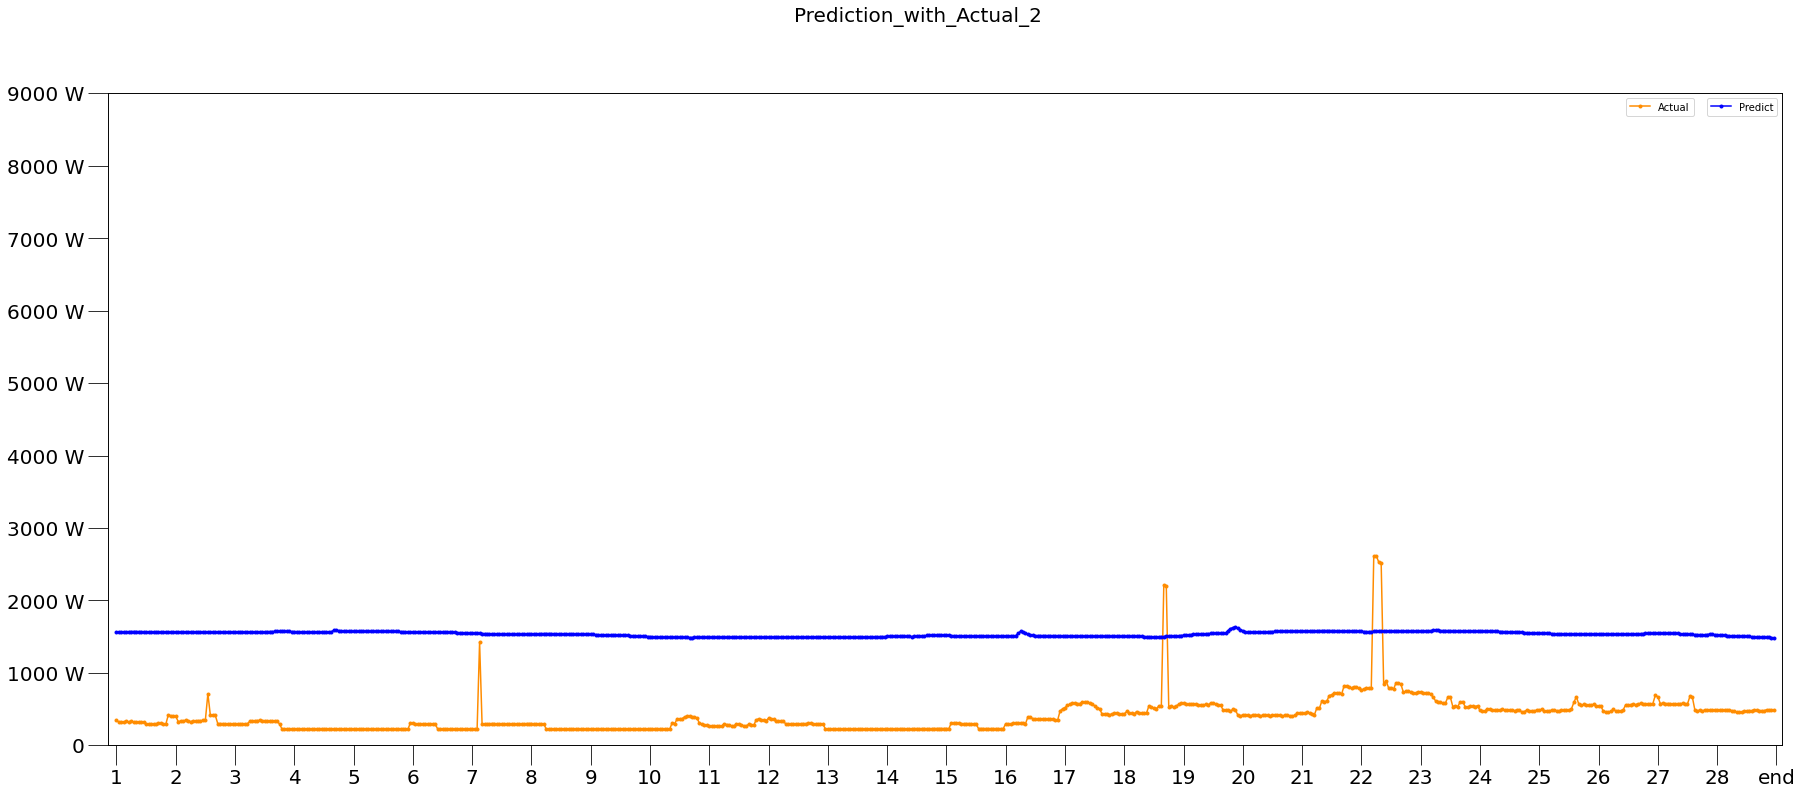

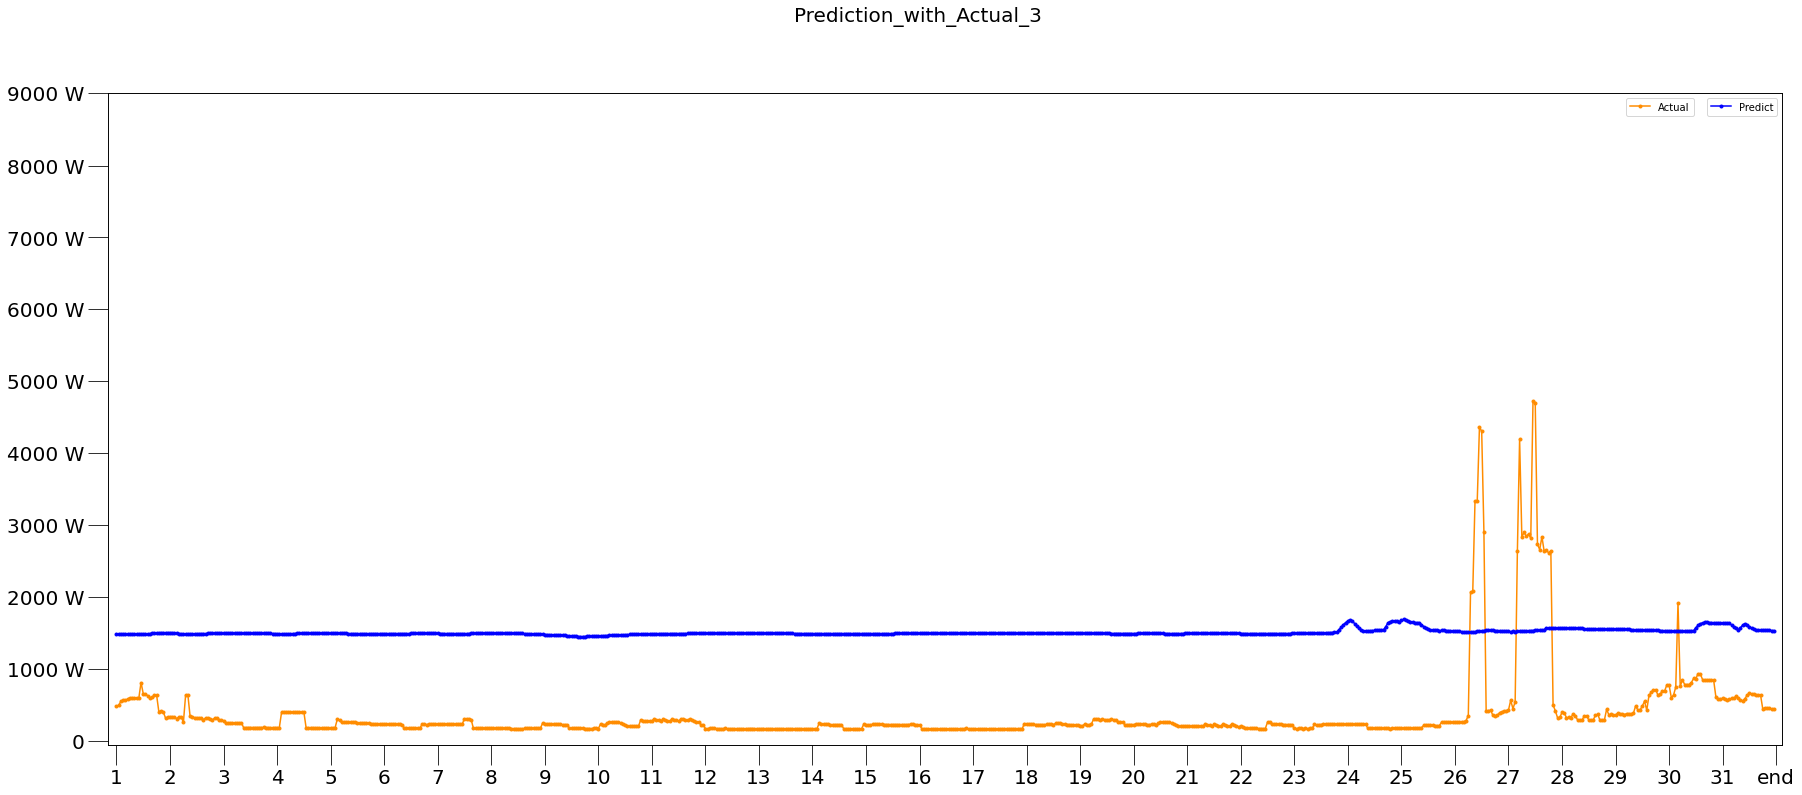

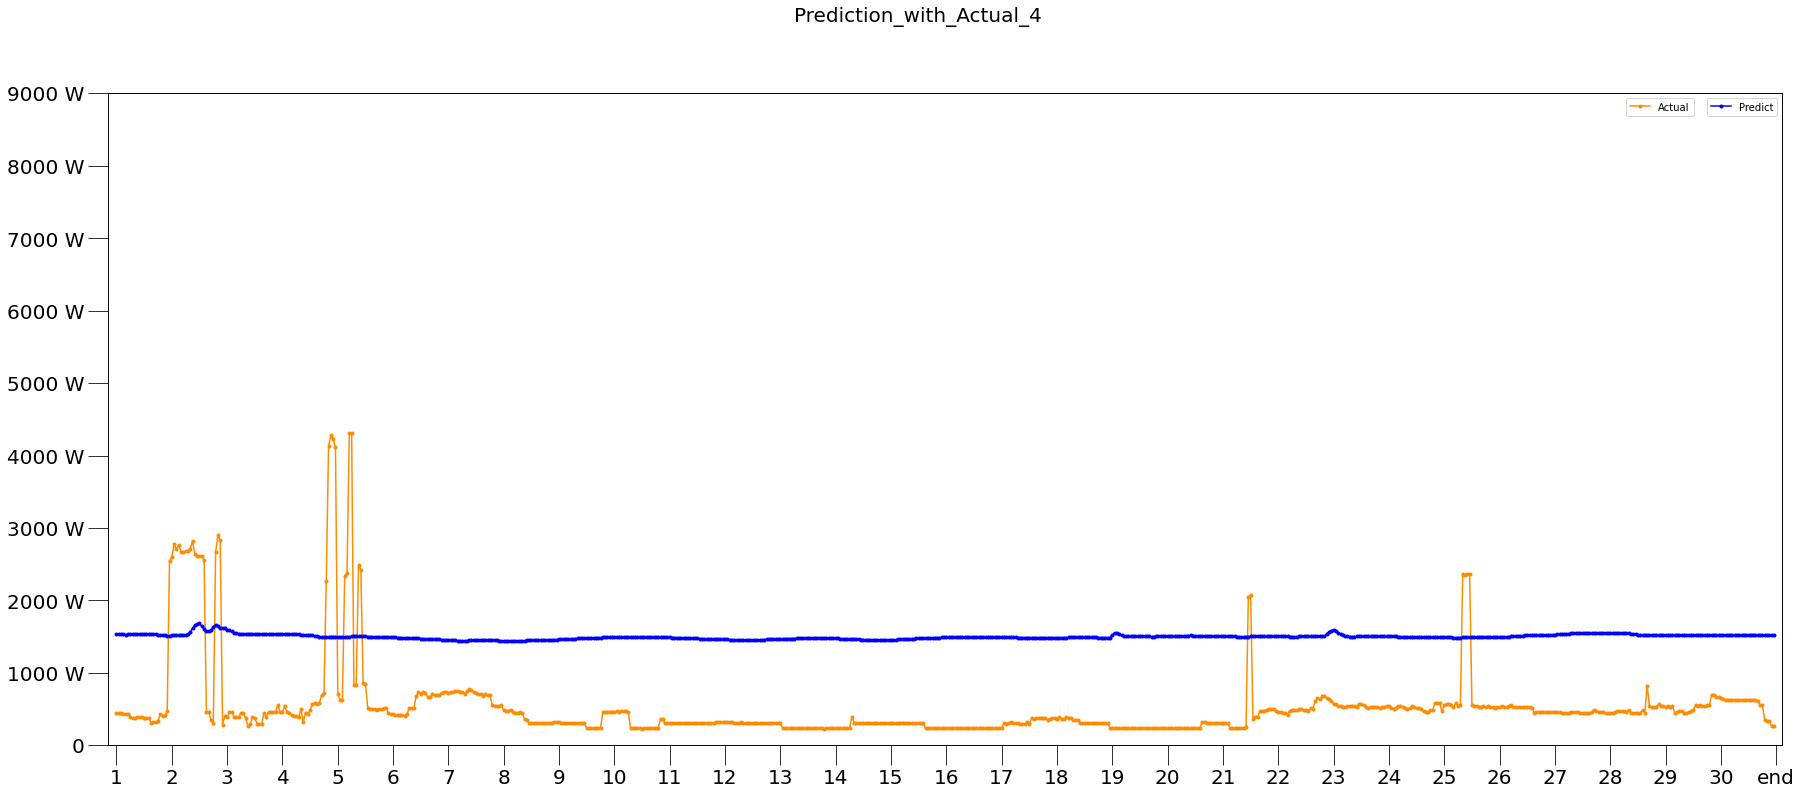

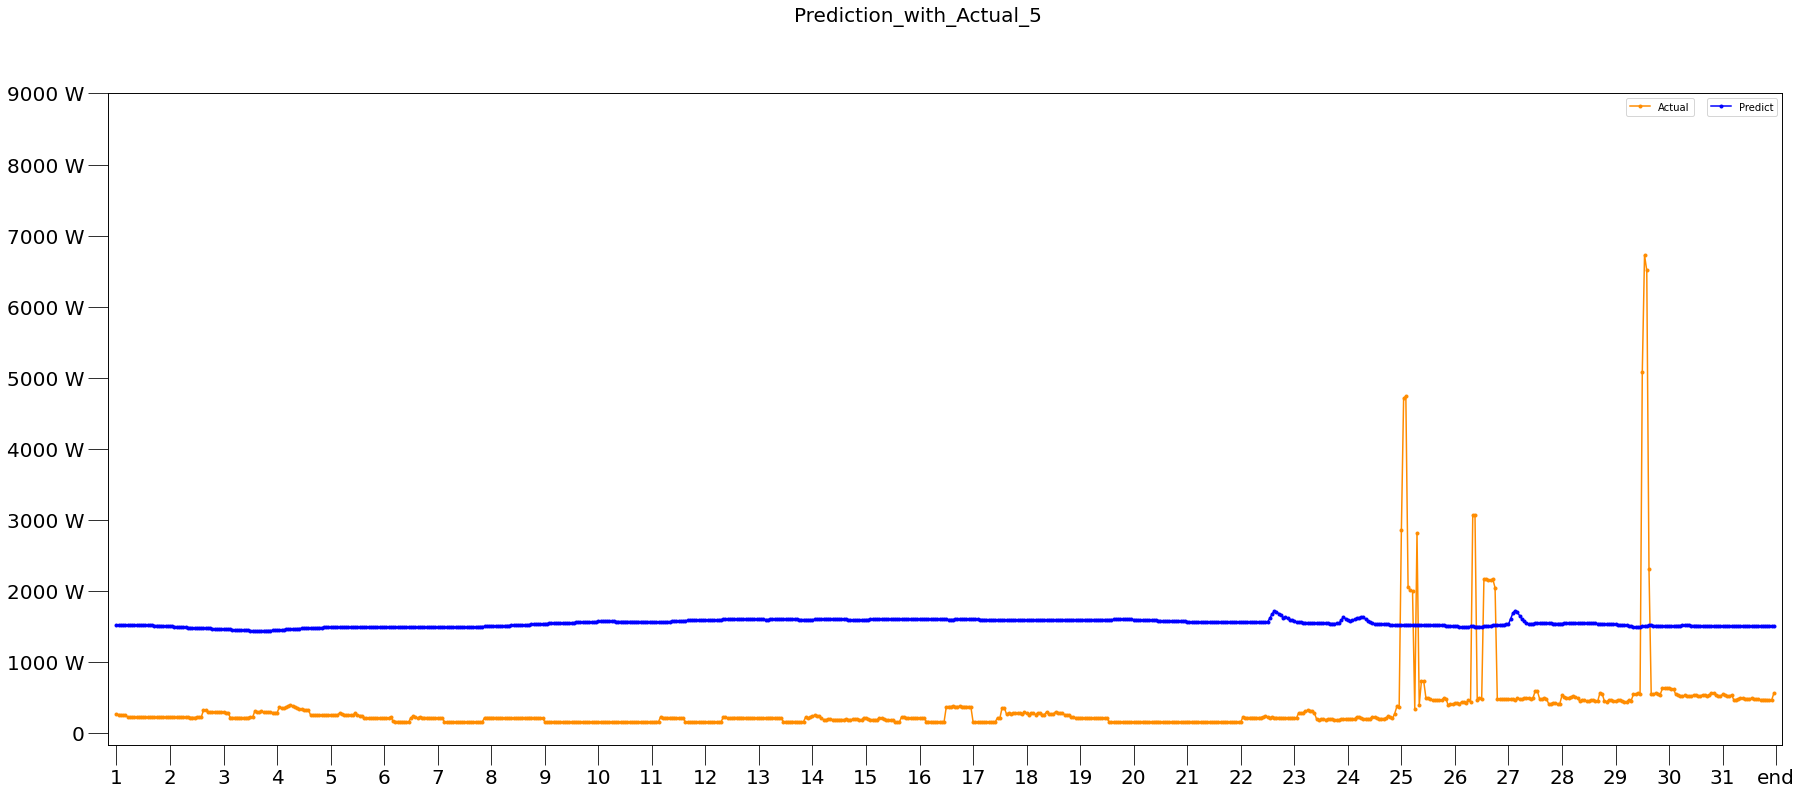

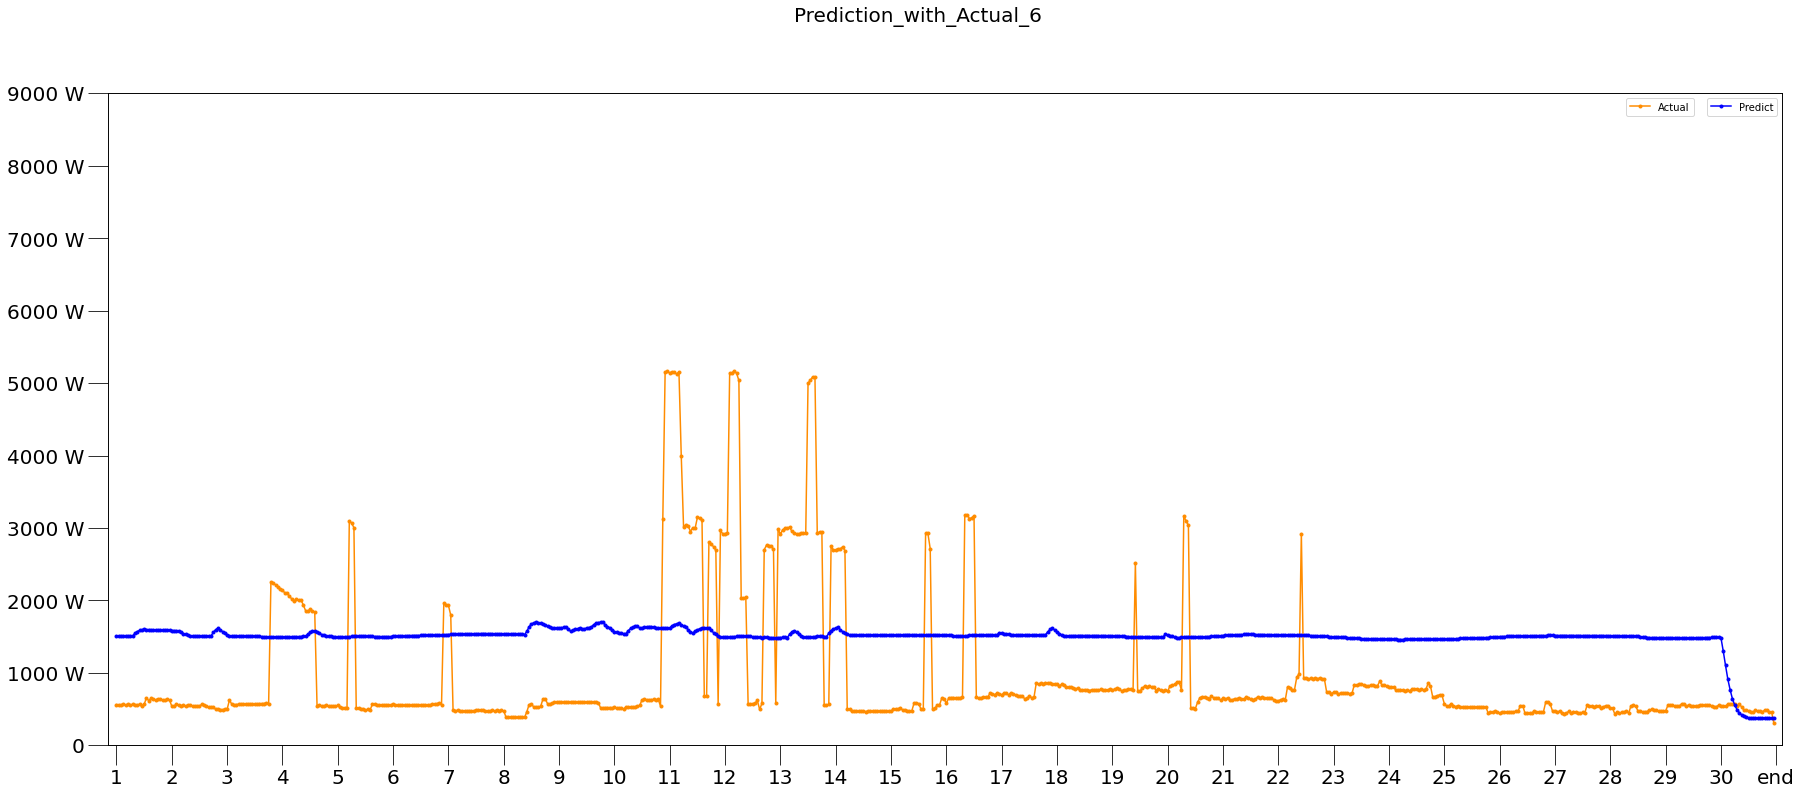

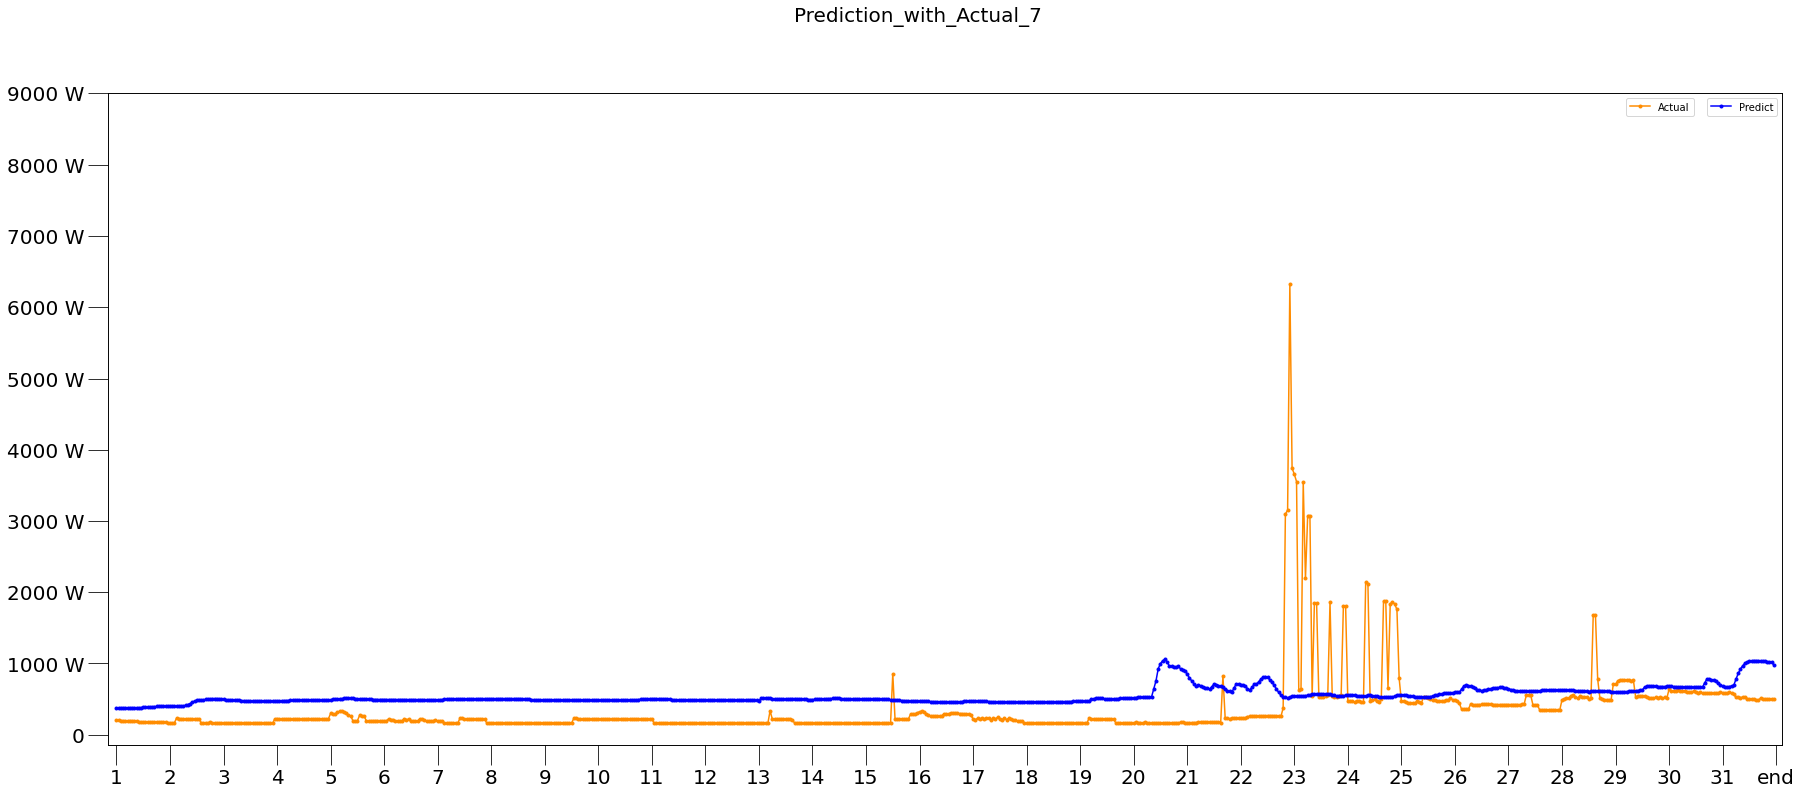

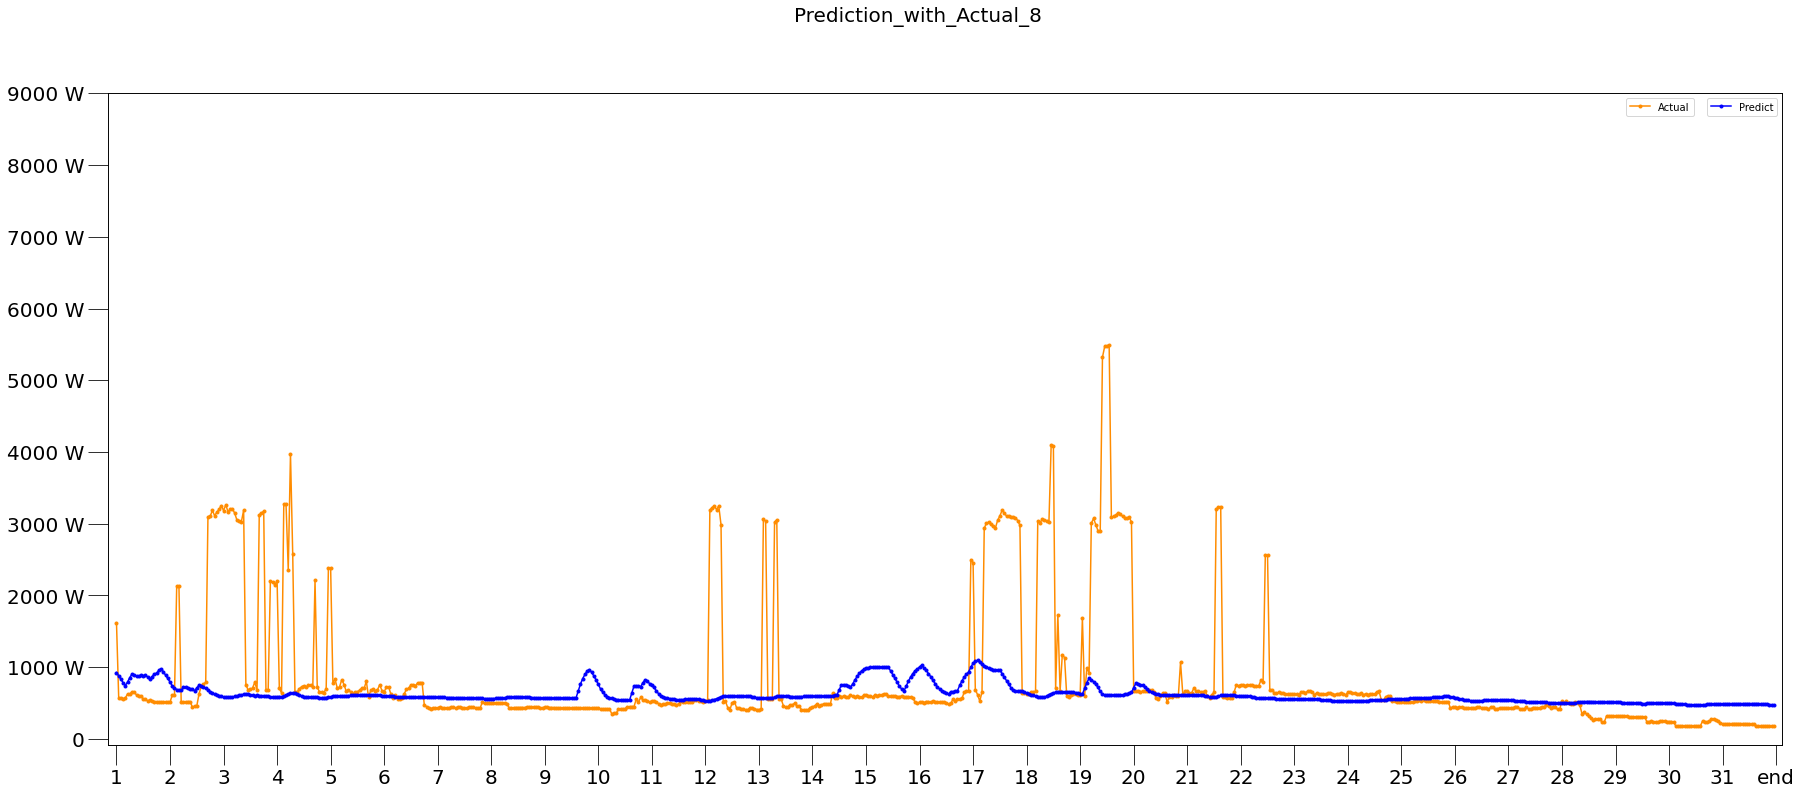

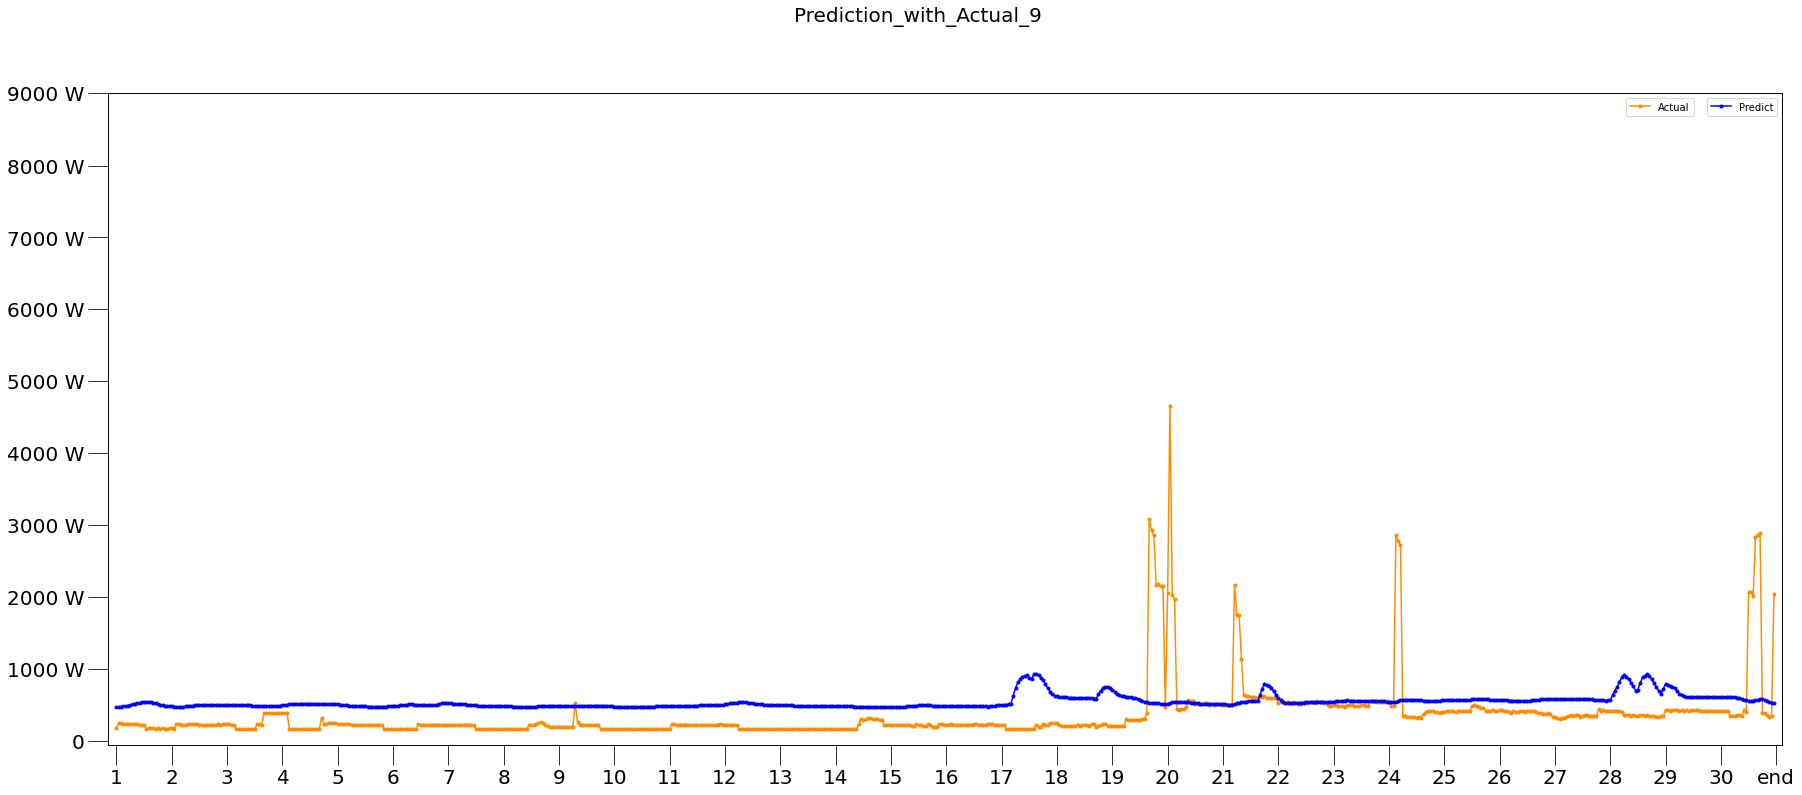

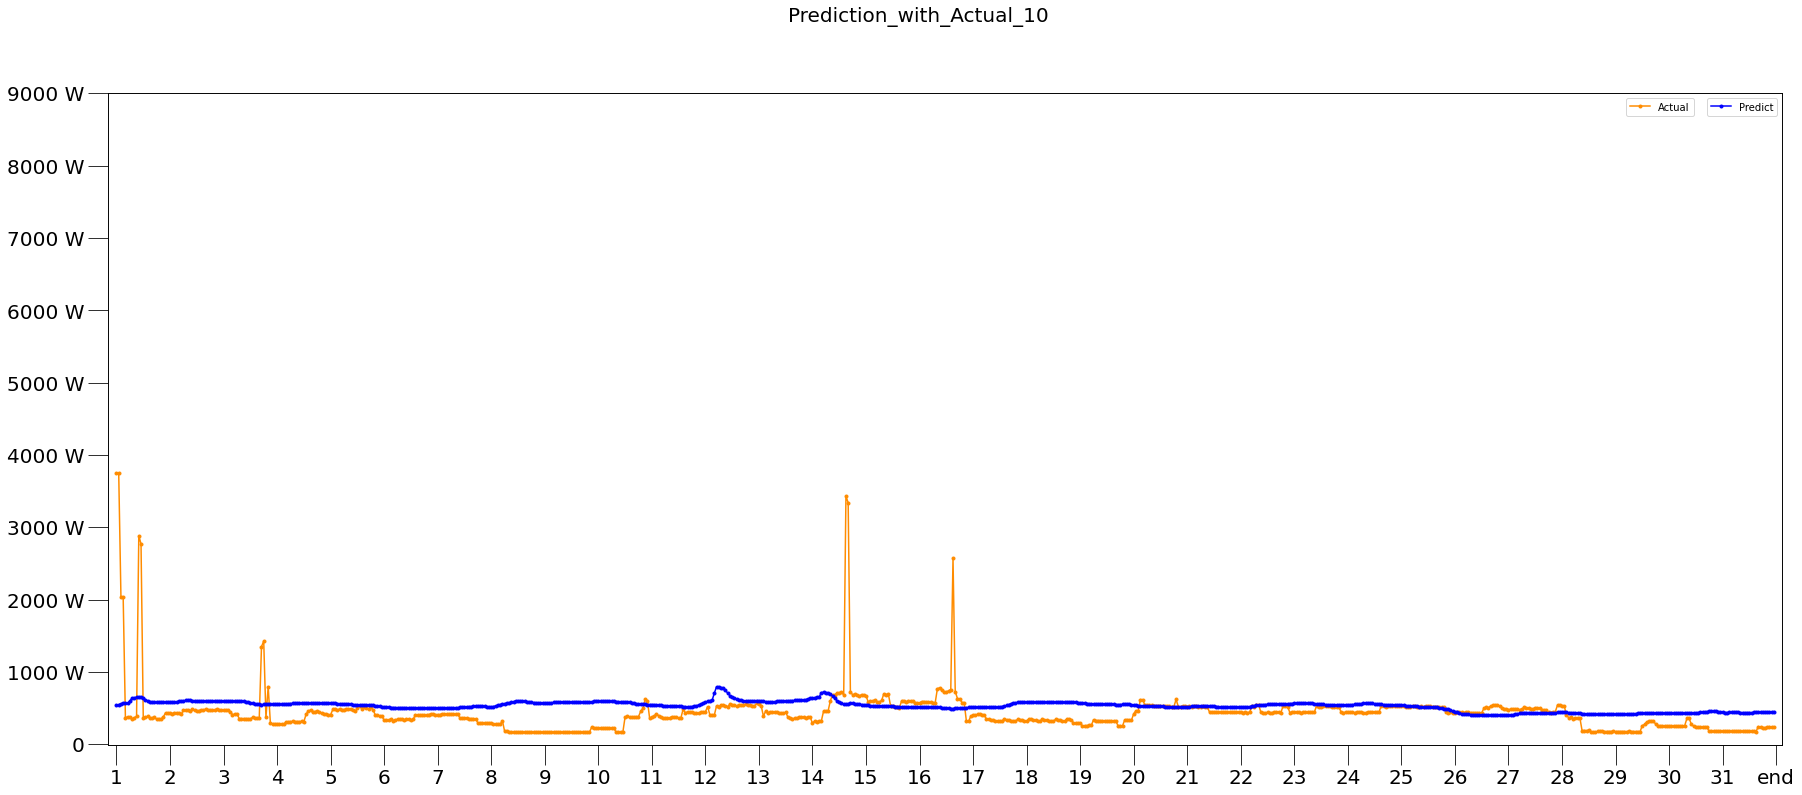

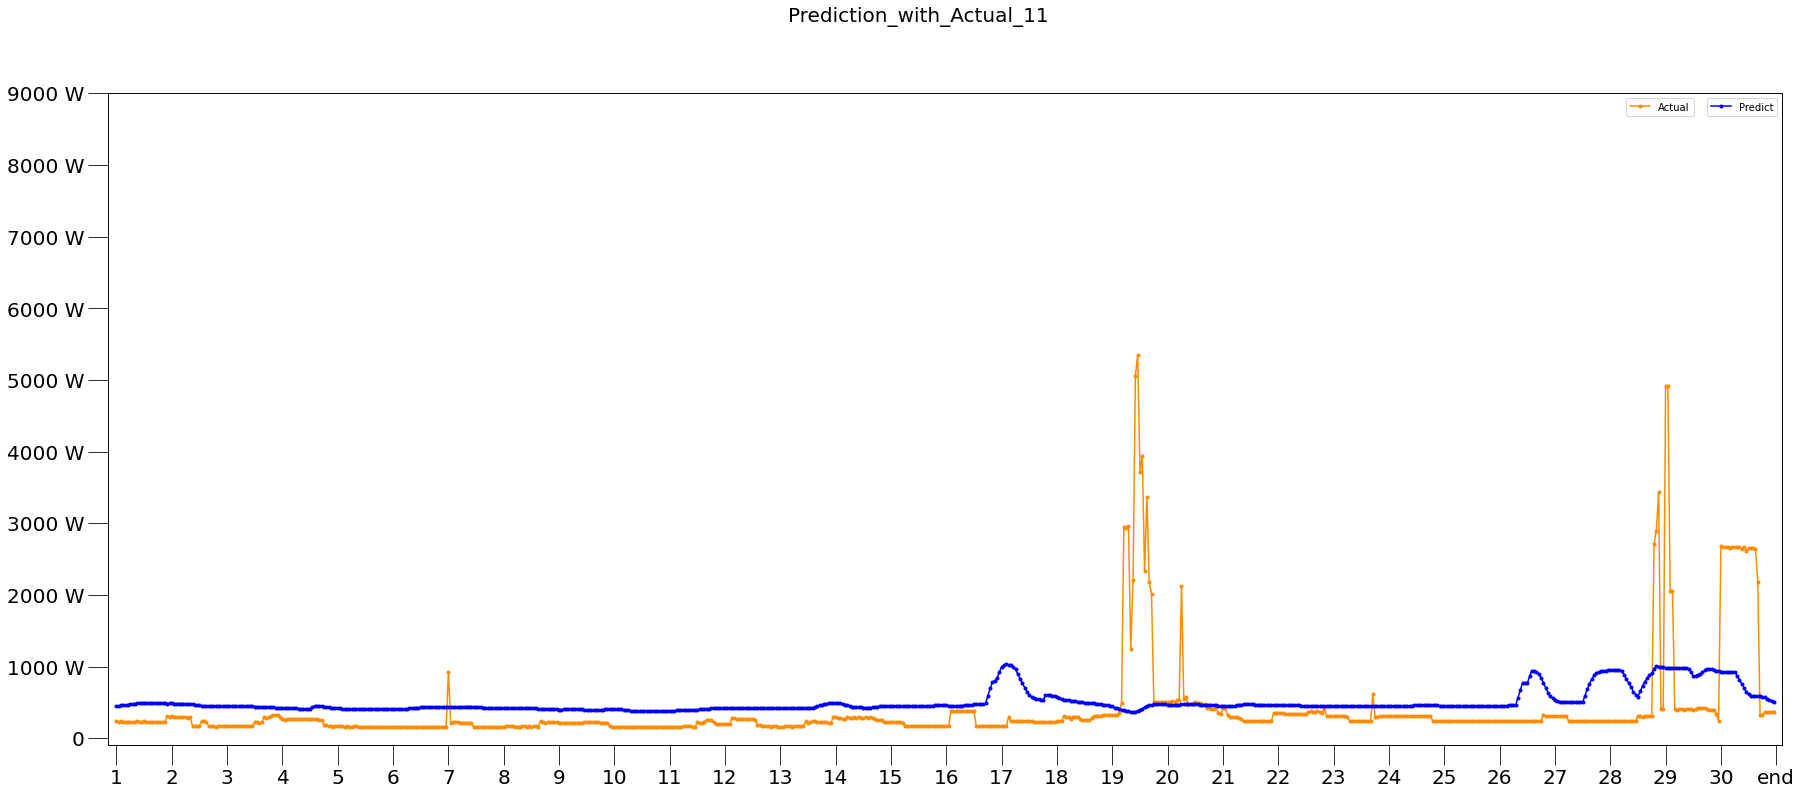

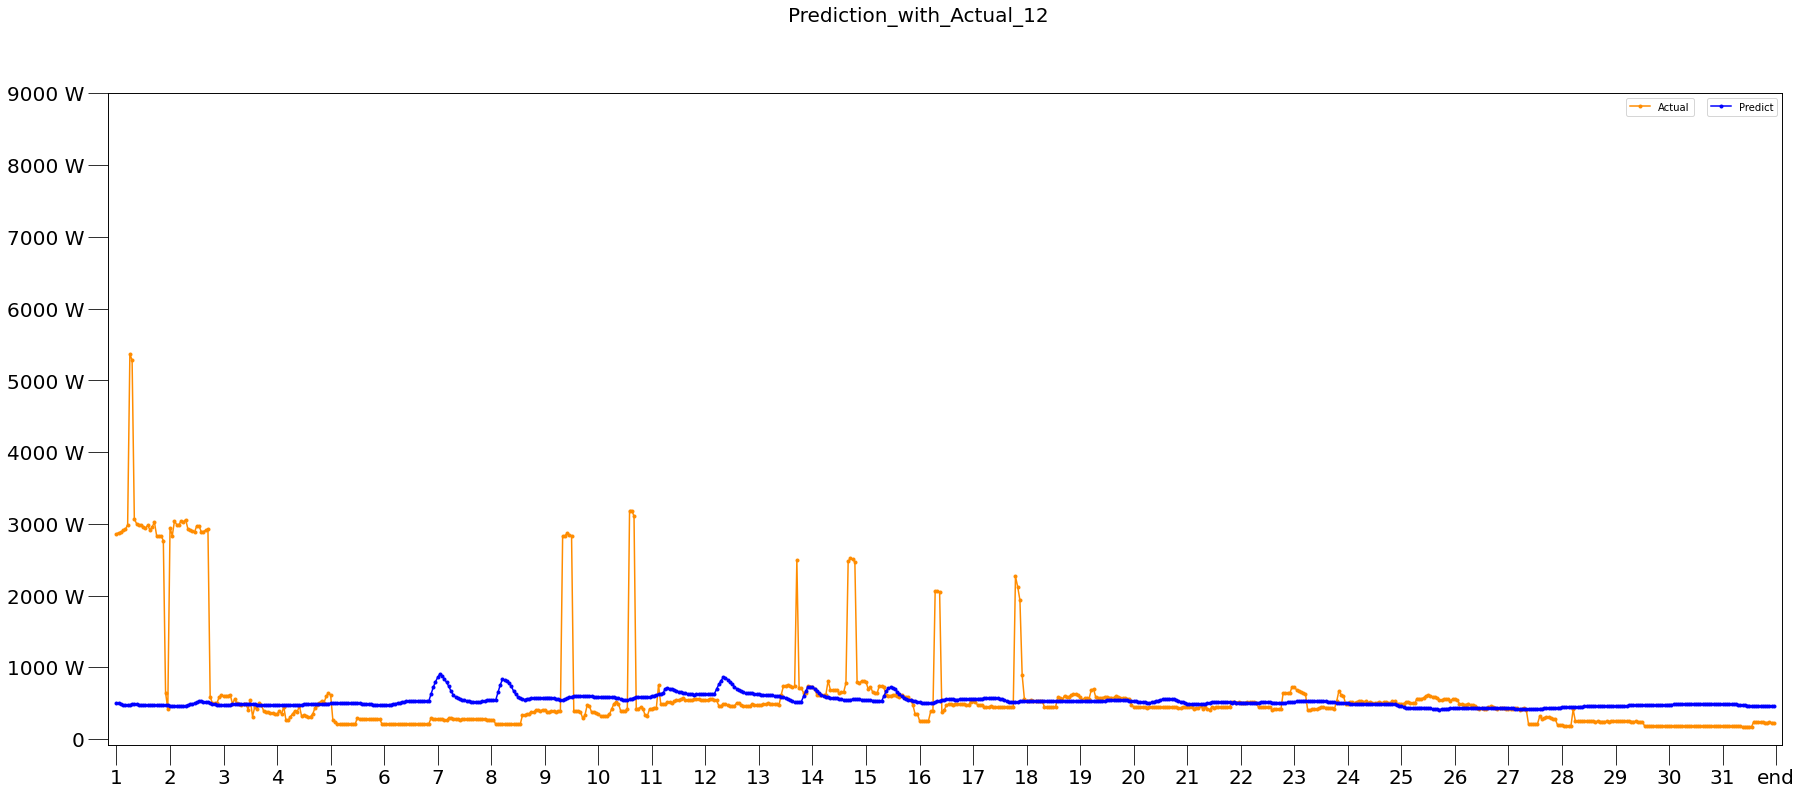

In [21]:
# 월 단위 그래프 분할 표시 및 저장
for m in range(1,13):
    month = {0:0, 1:31, 2:28, 3:31, 4:30, 5:31, 6:30, 7:31, 8:31, 9:30, 10:31, 11:30, 12:31}
    
    start = {1:0, 2:744, 3:1416, 4:2160, 5:2880, 6:3624, 7:4344, 8:5088, 9:5832, 10:6552, 11:7296, 12:8016}
    end = {1:744, 2:1416, 3:2160, 4:2880, 5:3624, 6:4344, 7:5088, 8:5832, 9:6552, 10:7296, 11:8016, 12:8760}
        
    ax2.set_title('Prediction & Actual Graph - month'+str(m), size='15')
    
    watt_list=TEST['Watt'][:-WINDOW_SIZE].tolist()
    
    fig = plt.figure(figsize=(30,12)) 
    ax1 = fig.add_subplot() # subplot 그래프 생성
    ax1.tick_params(axis='y', size=20, labelsize=20) # y축 눈금 표기 설정
    ax1.set_yticks([0, 0.111, 0.222, 0.333, 0.444, 0.555, 0.666, 0.777, 0.888, 1.0], 
           labels=['0', '1000 W', '2000 W', '3000 W', '4000 W', '5000 W', '6000 W', '7000 W', '8000 W','9000 W'])
    
    # Actual
    color1 = 'darkorange'
    ax1.plot(watt_list[start[m]:end[m]], color=color1, marker='.')
    ax1.tick_params(axis='x', size=20, labelsize=20)
    ax1.margins(x=0.005)
    ax1.legend(['Actual'], loc=1, bbox_to_anchor=(0.95, 1, 0, 0))
    
    # Predict
    color2 = 'blue'
    ax2 = ax1.twiny()
    ax2.plot(pred[start[m]:end[m]], color=color2, marker='.')
    ax2.tick_params(axis='x', size=20, labelsize=20)
    ax2.xaxis.set_visible(False)
    ax2.margins(x=0.005)
    ax2.legend(['Predict'], loc=1, bbox_to_anchor=(1, 1, 0, 0))
    
    # 월별 xticks 설정 함수
    def xticks_list (days):
        xticks_list=[]
        for x in range(0,days+1):
            xticks_list.append(x*24)
        return xticks_list
    
    # month labels 설정 함수
    def month_labels (days):
        month_labels=[]
        for ml in range(1,days+1):
            month_labels.append(ml)
        month_labels.append('end') 
        return month_labels
    
    if (m==2):
        ax1.set_xticks(xticks_list(28), labels=month_labels(28))

    if (m==4 or m==6  or m==9 or m==11):
        ax1.set_xticks(xticks_list(30), labels=month_labels(30))
        
    if (m==1 or m==3 or m==5 or m==7 or m==8 or m==10 or m==12):
        ax1.set_xticks(xticks_list(31), labels=month_labels(31))
        
    ax1.set_yticks([0, 0.111, 0.222, 0.333, 0.444, 0.555, 0.666, 0.777, 0.888, 1.0], 
           labels=['0', '1000 W', '2000 W', '3000 W', '4000 W', '5000 W', '6000 W', '7000 W', '8000 W','9000 W'])
    
    plt.suptitle('Prediction_with_Actual_'+str(m),fontsize=20)
    plt.grid(True)
    plt.savefig('./Result/CNN+LSTM/Graph/Prediction_with_Actual_'+str(m)+'.png')
    plt.show()

#### 그래프 비교 결과

In [29]:
import cv2
from skimage.metrics import structural_similarity as ssim

In [30]:
# 유사도 측정을 위한 이미지 가공
image1 = cv2.imread('./Result/CNN+LSTM/Graph/Prediction.png')
image2 = cv2.imread('./Result/CNN+LSTM/Graph/Actual.png')

tempDiff1 = cv2.subtract(image1, image2)

gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

In [31]:
# 차이 추출을 위한 뺄셈 과정
pred_list=pred.tolist()
actual_list=TEST['Watt'][:-WINDOW_SIZE].tolist()

In [32]:
(score, diff) = ssim(gray1, gray2, full=True)
sim_score = round(score,5)*100

print('그래프 유사도 ==>> %.3f %%' %sim_score)

그래프 유사도 ==>> 76.925 %


#### 성능 측정 지표

In [33]:
true = TEST['Watt'][:-WINDOW_SIZE].to_numpy()
true = true.reshape(-1,1)

In [34]:
from sklearn.metrics import r2_score as r2
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE

MAE = MAE(true, pred)
RMSE = np.sqrt(MSE(true, pred))

print('r2 >> %.4f' %r2(true, pred)) # 1에 가까워야 좋음
print('MAE >> %.4f' %MAE) # 0에 가까워야 좋음
print('RMSE >> %.4f' %RMSE) # 0에 가까워야 좋음

r2 >> 0.2817
MAE >> 0.1633
RMSE >> 0.2144


In [35]:
MAE_pct = round(1-MAE, 5)*100
RMSE_pct = round(1-RMSE, 5)*100
print('MAE 측정 정확도 ==>> %.3f %%' %MAE_pct)
print('RMSE 측정 정확도 ==>> %.3f %%' %RMSE_pct)

MAE 측정 정확도 ==>> 83.667 %
RMSE 측정 정확도 ==>> 78.562 %
